# Introduction to xarray

In the pandas notebook you got a sense of how pandas can make working with tabular data easier. In some ways, [xarray](http://xarray.pydata.org/en/stable/) generalized these concepts to multi-dimensional arrays. NumPy itself supports multi-dimensional arrays, but provides no means to add labels or coordinates to the different dimensions, meaning you have to keep track of this yourself. Xarray make labelled multi-dimensional arrays simple, efficient, and fun.

It works cleverly with the [dask](https://dask.org/) project to handle datasets that are larger than memory. By default many operations are lazy, meaning that it will only do the actual computation when it is needed, rather than when it is defined.

The xarray data structures are comparable to those of NetCDF. At Deltares use xarray for instance to build functionality for creating and analyzing groundwater models, see https://deltares.gitlab.io/imod/imod-python/.

In [1]:
import xarray as xr
import pathlib

In [2]:
%matplotlib inline

## Stations over time
Set the correct paths to the data sources.

In [3]:
datadir = pathlib.Path("data")
district_nc_path = datadir / "LHM_ZW_LHM_MozartDistrict_REF2017BP18.nc"
etact_nc_path = datadir / "etact.nc"

Open the NetCDF file with [xarray.open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html), which returns a [xarray.Dataset](http://xarray.pydata.org/en/stable/data-structures.html#dataset) object.

At a glance we can see the different data variables in our dataset, and the dimensions along which they are defined. The attributes lists the metadata embedded in this file.

In [4]:
ds1 = xr.open_dataset(district_nc_path)
ds1

<xarray.Dataset>
Dimensions:             (analysis_time: 1, stations: 244, time: 3636)
Coordinates:
  * analysis_time       (analysis_time) datetime64[ns] 2012-01-01
    lat                 (stations) float64 ...
    lon                 (stations) float64 ...
  * time                (time) datetime64[ns] 1911-01-11 ... 2012-01-01
Dimensions without coordinates: stations
Data variables:
    y                   (stations) float64 ...
    x                   (stations) float64 ...
    z                   (stations) float64 ...
    station_id          (stations) |S64 ...
    station_names       (stations) |S255 ...
    precip              (time, stations) float32 ...
    evaporation         (time, stations) float32 ...
    drainage_sh         (time, stations) float32 ...
    drainage_dp         (time, stations) float32 ...
    infiltration_sh     (time, stations) float32 ...
    infiltration_dp     (time, stations) float32 ...
    urbanrunoff         (time, stations) float32 ...
    upstre

If we take out a single data variable, we get a [xarray.DataArray](http://xarray.pydata.org/en/stable/data-structures.html#dataarray) object back. This has its own metadata such as units, and keeps the dimensions and coordinates with the data.

In [5]:
evap = ds1["evaporation"]
evap

<xarray.DataArray 'evaporation' (time: 3636, stations: 244)>
[887184 values with dtype=float32]
Coordinates:
    lat      (stations) float64 ...
    lon      (stations) float64 ...
  * time     (time) datetime64[ns] 1911-01-11 1911-01-21 ... 2012-01-01
Dimensions without coordinates: stations
Attributes:
    long_name:            evaporation
    units:                m3
    timeseries_sets_xml:  <?xml version="1.0" encoding="UTF-8"?>\n<timeSeries...

Xarray supports [groupby](http://xarray.pydata.org/en/stable/groupby.html) operations, so we can easily find the smallest evaporation measured at each station:

In [6]:
evap.groupby("stations").min()

c:\bin\anaconda\envs\geo\lib\site-packages\xarray\core\groupby.py:713: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


<xarray.DataArray 'evaporation' (stations: 244)>
array([ -212394.33, -1054508.9 ,  -494433.97, ...,  -202569.81,   -43259.75,
        -127666.8 ], dtype=float32)
Coordinates:
    lat      (stations) float64 ...
    lon      (stations) float64 ...
Dimensions without coordinates: stations

## Rasters over time
Now let's open a different dataset. Even though the NetCDF is around 600 MB, `xarray.open_dataset` returns almost instantaneously. This is because it only reads the dimensions and metadata, but waits with loading in the data until it needs to.

We directly select the `etact` parameter to get a 100 x 1300 x 1200 array back, which represents the actual yearly evapotraspiration over a period of 100 years. For each timestep we have a 1300 x 1200 geospatial raster.

In [7]:
da = xr.open_dataset(etact_nc_path)["etact"]
da

<xarray.DataArray 'etact' (time: 100, y: 1300, x: 1200)>
[156000000 values with dtype=float32]
Coordinates:
  * x        (x) float64 125.0 375.0 625.0 ... 2.994e+05 2.996e+05 2.999e+05
  * y        (y) float64 6.249e+05 6.246e+05 6.244e+05 ... 3.004e+05 3.001e+05
    dx       float64 ...
    dy       float64 ...
  * time     (time) datetime64[ns] 1912-12-31 1913-12-31 ... 2011-12-31

Since the `x` and `y` coordinates are attached to the data, we can use them to get the values at single (x, y) location using [sel](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.sel.html). The `method="nearest"` ensures we don't need to be exactly in the middle of a data cell, but it will select the nearest one. Since we select `x` and `y` but not `time`, we are left with a `DataArray` with only the `time` dimension left.

In [8]:
da.sel(x=125_000.5, y=440_000, method="nearest")

<xarray.DataArray 'etact' (time: 100)>
array([345.522, 342.   , 380.255, 374.848, 353.472, 381.954, 358.17 , 354.824,
       359.254, 380.427, 357.153, 342.635, 355.29 , 364.76 , 346.197, 346.51 ,
       386.005, 377.293, 366.383, 359.65 , 353.596, 387.436, 388.383, 377.026,
       363.943, 346.524, 355.639, 385.549, 383.539, 359.807, 391.197, 381.779,
       373.073, 379.809, 378.121, 418.566, 384.61 , 397.854, 384.467, 386.339,
       393.445, 389.623, 351.964, 385.161, 336.749, 371.99 , 364.356, 414.106,
       356.652, 359.366, 345.667, 352.132, 385.929, 353.238, 364.495, 374.691,
       351.963, 385.035, 365.341, 391.662, 352.545, 383.732, 375.286, 388.015,
       395.741, 341.723, 347.43 , 351.594, 360.368, 343.431, 387.244, 359.066,
       332.303, 351.277, 369.061, 343.12 , 343.459, 382.96 , 386.581, 350.387,
       381.778, 350.713, 360.172, 381.315, 356.108, 378.944, 333.118, 390.393,
       362.626, 386.633, 364.597, 391.298, 379.424, 388.875, 383.588, 381.816,
       377.81

This is a timeseries at a single location. Use the [plot](http://xarray.pydata.org/en/stable/plotting.html) method to quickly visualize the data.

c:\bin\anaconda\envs\geo\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


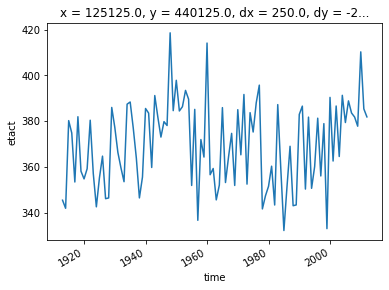

In [9]:
da.sel(x=125_000, y=440_000, method="nearest").plot()

Compared to `sel`, `isel` expects not coordinate values but integer indices. If we select only a `x` index, we are left with a two dimensional `y`, `time`, dataset, of which we can make a picture. Xarray will automatically give the right axis labels.

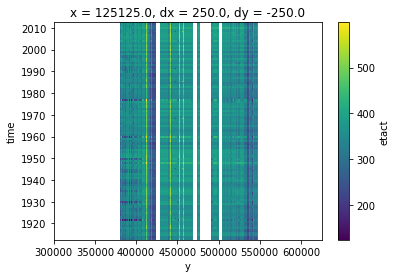

In [10]:
da.isel(x=500).plot()

To just get the last timestep, combine `isel` with the `-1` index, which refers to the last one.

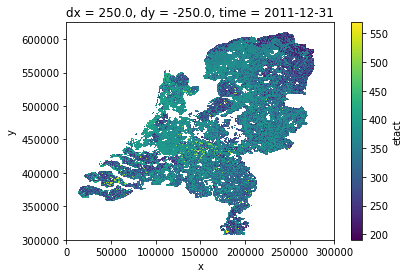

In [11]:
da.isel(time=-1).plot()

If we want to analyze spatial patterns, we can take the median over the `time` axis:

c:\bin\anaconda\envs\geo\lib\site-packages\numpy\lib\nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


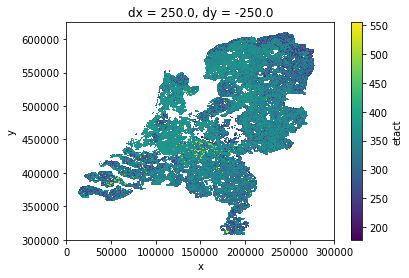

In [12]:
da.median("time").plot()

With some simple basics, xarray can allow powerful analysis over large datasets.

Take the following one liner for instance. Note that just because it fits on one line, doesn't mean that it should! Also think about the readability of your code. Try to look at it to figure out what it does, it's not easy.

c:\bin\anaconda\envs\geo\lib\site-packages\xarray\core\nputils.py:220: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
c:\bin\anaconda\envs\geo\lib\site-packages\xarray\core\nputils.py:220: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


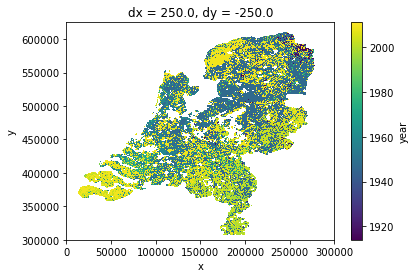

In [13]:
da["time.year"].where(da == da.max("time")).min("time").plot()

- `da["time.year"]` gives a DataArray with for each time, the year as an integer
- `da.where(sel)` gives the da back at indices where `sel` is `True`, and `np.nan` otherwise.
- `da == da.max("time")` is `True` once per location; at the time that the `etact` was the highest is the series
- The above 3 steps combined give us a 3D DataArray, with only one non-missing value along the time dimension. We want a 2D one with no time dimension. To do this we can simply take a `min` (or `max`) along that coordinate, since it will return the one data value we are interested in.